In [1]:
import os
import sys
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader
import numpy as np
import einops
import wandb
import plotly.express as px
from pathlib import Path
import itertools
import random
from IPython.display import display
import wandb
from jaxtyping import Float, Int, Bool, Shaped, jaxtyped
from typing import Union, Optional, Tuple, Callable, Dict
from collections import Counter
import typeguard
from functools import partial
import copy
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
import pandas as pd
import torch
import matplotlib.pyplot as plt


import circuits.eval_sae_as_classifier as eval_sae
import circuits.analysis as analysis
import circuits.eval_board_reconstruction as eval_board_reconstruction
import circuits.get_eval_results as get_eval_results
import circuits.f1_analysis as f1_analysis
import circuits.utils as utils
import circuits.pipeline_config as pipeline_config
from circuits.dictionary_learning.dictionary import AutoEncoder, GatedAutoEncoder, AutoEncoderNew
import common
import chess_utils
import chess
#from plotly_utils import imshow
#from neel_plotly import scatter, line



device = t.device('cuda' if t.cuda.is_available() else 'cpu')
import pickle
with open('meta.pkl', 'rb') as picklefile:
    meta = pickle.load(picklefile)

/opt/conda/envs/chessgpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
autoencoder = common.load_autoencoder(device)
model = common.load_model(device)
dataset = common.get_dataset(device)
TRAIN_TEST_GAME_SPLIT = 2500
rows_to_include = 100
features_to_include = 4096

/opt/conda/envs/chessgpt/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading statistics aggregation dataset


In [3]:
encoded_inputs_tensor = t.stack([t.tensor(x) for x in dataset['encoded_inputs']]).to(device)
encoded_inputs_tensor = encoded_inputs_tensor[:rows_to_include]
is_check = dataset['board_to_check_state'].squeeze(-1)
is_this_a_dot = (encoded_inputs_tensor == meta['stoi']['.']).to(device)
is_this_a_dot = is_this_a_dot[:rows_to_include].long()
piece_letters = ['B', 'K', 'N', 'Q','R']
column_letters = 'abcdefgh'
is_this_a_space = (encoded_inputs_tensor == meta['stoi'][' ']).to(device)
is_this_a_space = is_this_a_space.long()
is_this_a_space = is_this_a_space[:rows_to_include]
is_this_an_x = (encoded_inputs_tensor == meta['stoi']['x']).to(device).long()
is_this_a_piece = t.isin(encoded_inputs_tensor, t.tensor([meta['stoi'][x] for x in piece_letters], device=device)).to(device).long()
is_this_a_column = t.isin(encoded_inputs_tensor, t.tensor([meta['stoi'][x] for x in column_letters], device=device)).to(device).long()



In [4]:
aggregation_results = common.get_aggregation_results(1000)
formatted_results = common.get_formatted_results(aggregation_results)
features_for_check_state = common.get_true_feature_indices(formatted_results, "board_to_check_state")
features_for_check_state = features_for_check_state.to(device)

In [5]:
#Collect all the activations for the features we care about
relevant_sae_activations = []
def get_activation(name, relevant_features):
    def hook(model, input, output):
        encoded_activations = autoencoder.encode(output[0]) # batch_size x len_seq x n_features_sae
        relevant_sae_activations.append(encoded_activations[:, :, relevant_features])
    return hook

t.set_grad_enabled(False)
activation_handle = model.transformer.h[5].register_forward_hook(get_activation(f"resid_stream_{5}", np.arange(features_to_include)))
num_batches = 50
batch_size = rows_to_include // num_batches
if device == 'cpu':
    num_batches = 1
    batch_size = 1
for i in range(num_batches):
    print(i)
    model(encoded_inputs_tensor[i*batch_size:(i+1)*batch_size])
    t.cuda.empty_cache()
activation_handle.remove()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [6]:
all_relevant_sae_activations = t.concat(relevant_sae_activations, dim=0) # batch_size x len_seq x n_check_features_sae
del relevant_sae_activations
t.cuda.empty_cache()
all_relevant_sae_activations.shape, is_this_a_dot.shape


(torch.Size([100, 256, 4096]), torch.Size([100, 256]))

In [7]:
def alternate_ones(row):
    # Find indices where there are 1s
    ones_indices = (row == 1).nonzero(as_tuple=True)[0]
    
    # Assign alternating 1 and 2
    for i, idx in enumerate(ones_indices):
        row[idx] = 1 if i % 2 == 0 else 2
    return row

# Apply the function to each row
result_tensor = torch.stack([alternate_ones(row.clone()) for row in is_this_a_space])
is_this_a_first_space = result_tensor==1
is_this_a_second_space = result_tensor==2


In [8]:
is_this_tensors_labels = ['dot', 'column', 'piece', 'first_space', 'second_space', 'x']
is_this_tensors_list = [is_this_a_dot, is_this_a_column, is_this_a_piece, is_this_a_first_space, is_this_a_second_space, is_this_an_x]
is_this_anything_else = t.ones_like(is_this_a_column) - sum(is_this_tensors_list)
is_this_tensors_list.append(is_this_anything_else)


In [9]:
activations_on_list = []
for is_this_tensor in is_this_tensors_list:
    activations_on_list.append( all_relevant_sae_activations * is_this_tensor.unsqueeze(-1))


In [10]:
max_activations = all_relevant_sae_activations.max(dim=0).values.max(dim=0).values
del all_relevant_sae_activations
del result_tensor
t.cuda.empty_cache()

In [11]:
threshold_multiplier = 0.2
num_activations_list = []
for activations_on in activations_on_list:
    num_activations_list.append((activations_on > threshold_multiplier * max_activations).sum(dim=0).sum(dim=0))


In [12]:
num_activations_tensor = t.stack(num_activations_list)

In [13]:
frac_of_total_in_one_category = num_activations_tensor.max(dim=0).values/num_activations_tensor.sum(dim=0)
frac_of_total_in_one_category = frac_of_total_in_one_category.cpu().numpy()

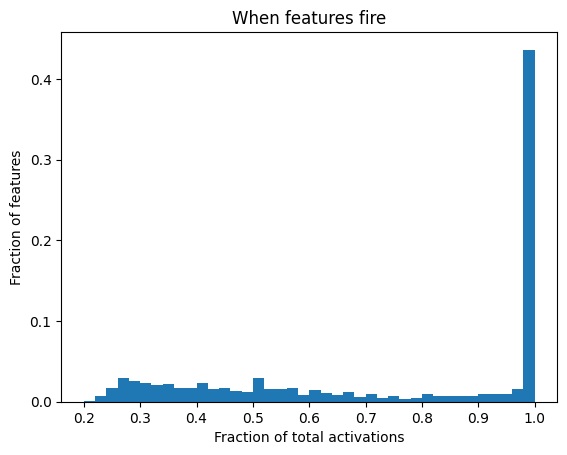

In [19]:
plt.title('When features fire')
plt.xlabel('Fraction of total activations')
plt.ylabel('Fraction of features')
plt.hist(frac_of_total_in_one_category, weights=np.ones_like(frac_of_total_in_one_category)/len(frac_of_total_in_one_category), bins=40)
plt.show()


In [15]:
max_indices = num_activations_tensor.max(dim=0).indices
token_type_to_features_dict = {i.item():[] for i in max_indices.unique()}
for feature_index, class_index in enumerate(max_indices):
    token_type_to_features_dict[class_index.item()].append(feature_index)



In [16]:
def intervene_activation(name, feature_index_list_to_boost, feature_index_list_to_suppress, strength):
    def hook(model, input, output):
        output_activations = output[0] # batch_size x len_seq x n_features_residual
        encoded_activations = autoencoder.encode(output_activations) # batch_size x len_seq x n_features_sae
        reconstruction_error = output_activations - autoencoder.decode(encoded_activations)
        encoded_activations[:, :, feature_index_list_to_boost] = strength * max_activations[feature_index_list_to_boost]
        encoded_activations[:, :, feature_index_list_to_suppress] = 0
        output_activations = autoencoder.decode(encoded_activations) + reconstruction_error
        return (output_activations, output[1])
    return hook

def get_baseline_logits():
    num_batches = 100
    batch_size = len(encoded_inputs_tensor) // num_batches
    baseline_logits_list = []
    for i in range(num_batches):
        baseline_logits = model(encoded_inputs_tensor[i*batch_size:(i+1)*batch_size]).logits
        baseline_logits_list.append(baseline_logits)
        t.cuda.empty_cache()
    combined_baseline_logits = t.concat(baseline_logits_list, dim=0)
    return combined_baseline_logits

def get_intervened_logits(feature_list_to_boost, feature_list_to_suppress, strength):
    num_batches = 100
    batch_size = len(encoded_inputs_tensor) // num_batches
    intervened_logits_list = []
    for i in range(num_batches):
        activation_handle = model.transformer.h[5].register_forward_hook(intervene_activation(f"resid_stream_{5}", feature_list_to_boost, feature_list_to_suppress, strength))
        intervened_logits = model(encoded_inputs_tensor[i*batch_size:(i+1)*batch_size]).logits
        intervened_logits_list.append(intervened_logits)
        activation_handle.remove()
        t.cuda.empty_cache()
    combined_intervened_logits = t.concat(intervened_logits_list, dim=0)
    return combined_intervened_logits

baseline_logits = get_baseline_logits()
averaged_baseline_logits = baseline_logits.mean(dim=0).mean(dim=0)

dot


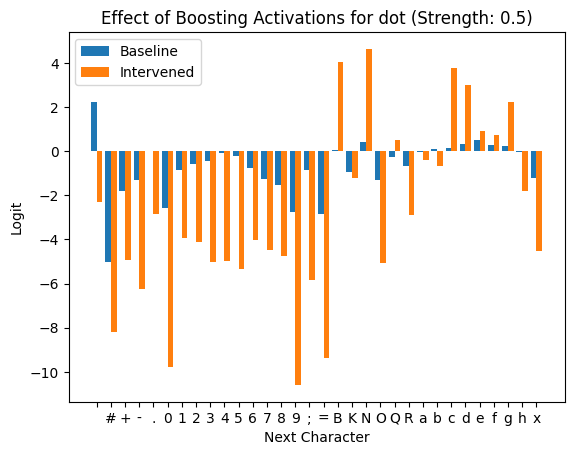

column


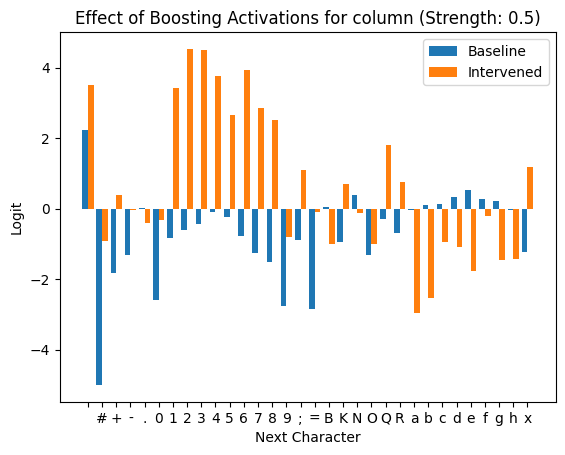

piece


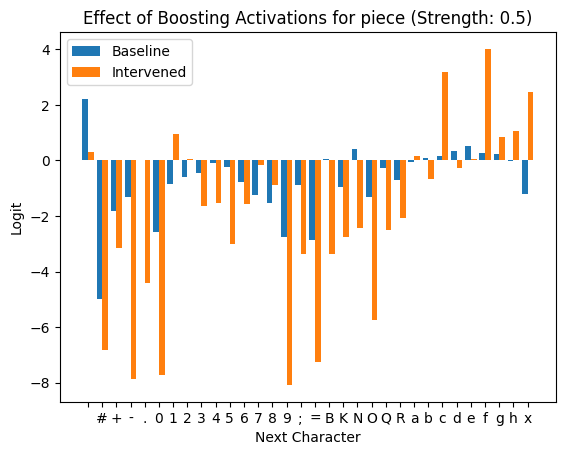

first_space


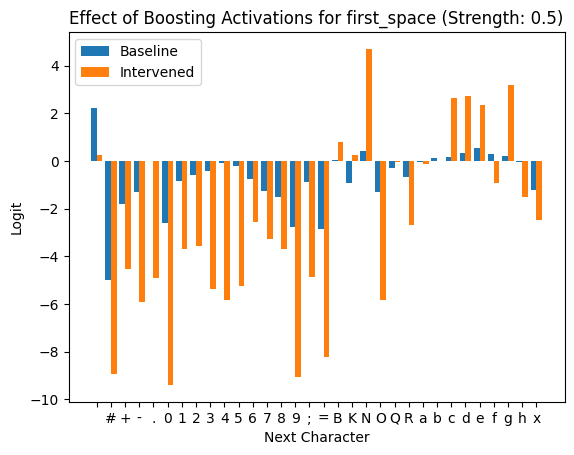

second_space


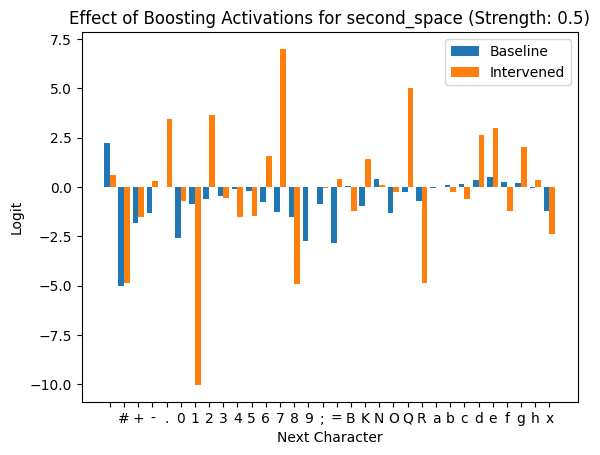

x


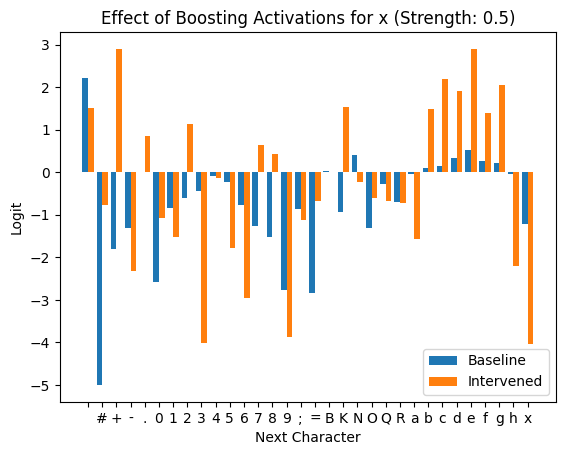

In [17]:
example_strength = 0.5

for class_to_boost in range(len(is_this_tensors_labels)):
    print(is_this_tensors_labels[class_to_boost])
    feature_index_list_to_boost = token_type_to_features_dict[class_to_boost]
    feature_index_list_to_suppress = [i for i in range(features_to_include) if i not in feature_index_list_to_boost]


    intervened_logits = get_intervened_logits(feature_index_list_to_boost, feature_index_list_to_suppress, example_strength)
    averaged_intervened_logits = intervened_logits.mean(dim=0).mean(dim=0)
    diff_logits = averaged_intervened_logits - averaged_baseline_logits
    X = [meta['itos'][i] for i in range(len(averaged_baseline_logits.cpu().numpy()))]
    y = averaged_baseline_logits.cpu().numpy()
    z = averaged_intervened_logits.cpu().numpy()
    X_axis = np.arange(len(X)) 
    
    plt.bar(X_axis - 0.2, y, 0.4, label = 'Baseline') 
    plt.bar(X_axis + 0.2, z, 0.4, label = 'Intervened') 
    
    plt.xticks(X_axis, X) 
    plt.xlabel("Next Character") 
    plt.ylabel("Logit") 
    plt.title(f"Effect of Boosting Activations for {is_this_tensors_labels[class_to_boost]} (Strength: {example_strength})") 
    plt.legend() 
    plt.show() 
